<a href="https://colab.research.google.com/github/Zaine-eng/Projetos-Machine_Learning/blob/main/Mini_Curso_S%C3%A9ries_temporais_Prof_Leon_S%C3%B3lon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Séries temporais**


Prof.: Leon Sólon 

Primeiro é preciso configurar o Colab para visualizar a base de dados a partir do Kaggle.

In [10]:
#install Kaggle
!pip install -q kaggle

lembre-se que ao gerar o código abaixo você deve procurar o arquivo API, vá na sua conta Kaggle e baixe, para ter acesso ao dataset.

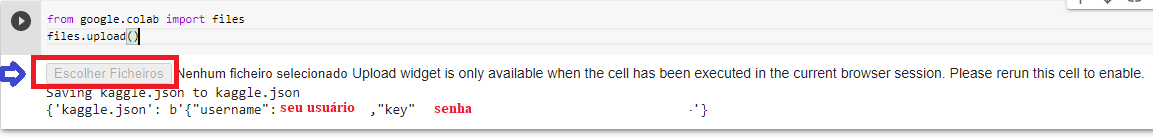

## Configurando o Colab com API do Kaggle

In [12]:
#criação de pasta kaggle

! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
# cópia do kaggle.json na pasta kaggle

! cp kaggle.json ~/.kaggle/

In [14]:
# permissão colab/kaggle
! chmod 600 ~/.kaggle/kaggle.json


In [16]:
import kaggle

In [17]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt

In [20]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

In [21]:
kaggle.api.authenticate()

In [22]:
kaggle.api.dataset_download_files('shenba/time-series-datasets', path= './data', unzip= True)

In [23]:
df = pd.read_csv('./data/Electric_Production.csv', index_col='DATE', parse_dates= True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Quantas linhas e colunas estamos trabalhando nesta base de dados? 

In [24]:
df.shape

(397, 1)

In [25]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


Renomeando nome da coluna para consumo, temos:

In [27]:
df.columns = ['consumo']
df.head()

,consumo
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Para saber o tamanho da nossa série temporal temos:

In [28]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

Fazendo uma plotagem rápida para vermos como os dados estão distribuidos no decorrer desde tempo.


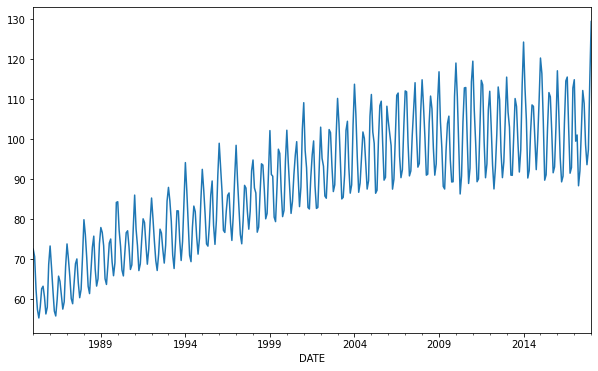

In [33]:
df['consumo'].plot(figsize=(10,6))

**Prevendo com ARIMA**

Começando com uma análise exploratória de dados para entender melhor nossos dados.

<Figure size 576x432 with 0 Axes>

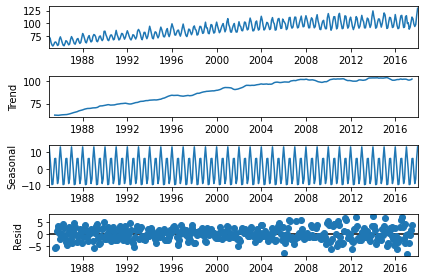

In [34]:
from statsmodels.tsa.seasonal import  seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize= (8,6))
fig = resultado.plot()

**Teste de estacionariedade**

In [41]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['consumo'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.2569903500472366
p-valor:0.18621469116587053


In [42]:
# diff () - calcula a diferença do dataframe comparando com outro elementto do dataframe.

from statsmodels.tsa.stattools import adfuller
result=adfuller(df['consumo'].diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-7.104890882267309
p-valor:4.0777865655394705e-10


Veja que a série passou a ser estacionária com a diferença realizada.

Aqui, estamos fazendo vários modelos de Arima para ver qual o melhor na nossa utilização.

In [47]:
fit_arima = auto_arima(df, d=1, satrt_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal = True,
                       n=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion='aic',
                       trace= True,
                       error_action = 'ignore',
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2235.015, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2463.436, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2219.925, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2300.788, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2229.093, Time=0.22 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 3.712 seconds


In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,arder=(3,1,1), seasonal_order =(0,0,0,0))
resultado_sarimax = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [56]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                  397
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1378.811
Date:                Mon, 25 Jul 2022   AIC                           2761.622
Time:                        01:26:29   BIC                           2769.590
Sample:                    01-01-1985   HQIC                          2764.778
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.004    246.091      0.000       0.989       1.005
sigma2        60.0712      5.507     10.909      0.000      49.278      70.864
===================================================================================
Ljung-Box (L1) (Q):                  55.86   Jarque-Bera (JB):                12.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [60]:
#intervalo de confiança 

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]
    

(99.29439482930819, 129.676037094851)

In [61]:
predicao_media[0]

114.4852159620796

In [62]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

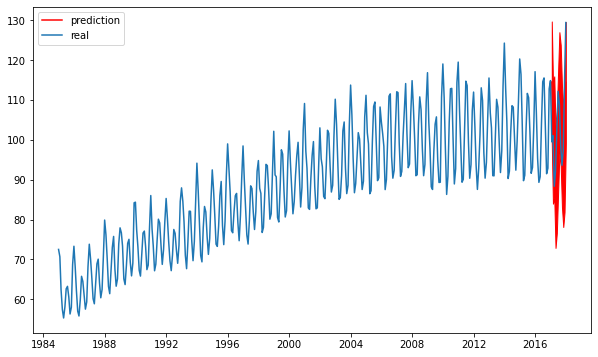

In [63]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao, predicao_media.values, color = 'red', label = 'prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color= 'red')
plt.plot(datas, df.values, label = 'real')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

rmse_sarima = sqrt(mean_squared_error(df[-12:].values, predicao_media.values))
print(rmse_sarima)


10.394980922433234


**FORECAST COM ARIMA**

In [68]:
# fORECAST para 12 valores

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean 
forecast_medio.size

12

In [71]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]
    

(113.80240462183757, 144.1840468873804)

In [73]:
forecast_medio[10]

124.9487967493753

In [74]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

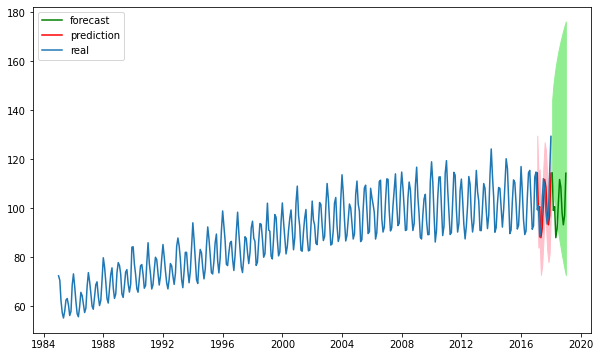

In [76]:
dates = np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast, predicao_media.values, color = 'green', label = 'forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color= 'lightgreen')

plt.plot(datas_previsao, predicao_media.values, color = 'red', label = 'prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color= 'pink')

plt.plot(datas, df.values, label = 'real')
plt.legend(loc='upper left')
plt.show()

**Prevendo com XGBoost**

In [77]:
df


,consumo
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [78]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (13, 1))

In [79]:
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [80]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

**Criando a variavel target e a lagged variable (já que é consumo, certo ?)**

In [81]:
treino['consumo']

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2016-08-01    115.5159
2016-09-01    102.7637
2016-10-01     91.4867
2016-11-01     92.8900
2016-12-01    112.7694
Name: consumo, Length: 384, dtype: float64

In [82]:
treino['consumo'].shift(-1)

DATE
1985-01-01     70.6720
1985-02-01     62.4502
1985-03-01     57.4714
1985-04-01     55.3151
1985-05-01     58.0904
                ...   
2016-08-01    102.7637
2016-09-01     91.4867
2016-10-01     92.8900
2016-11-01    112.7694
2016-12-01         NaN
Name: consumo, Length: 384, dtype: float64

In [83]:
treino['target'] = treino ['consumo'].shift(-1)
treino.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,consumo,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [85]:
treino.tail()

,consumo,target
DATE,,
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694
2016-12-01,112.7694,NaN


In [86]:
treino = treino.dropna()
treino.tail()

,consumo,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [87]:
validacao['target'] = validacao['consumo'].shift(-1)
validacao.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,consumo,target
DATE,,
2017-01-01,114.8505,99.4901
2017-02-01,99.4901,101.0396
2017-03-01,101.0396,88.3530
2017-04-01,88.3530,92.0805
2017-05-01,92.0805,102.1532


In [88]:
validacao.tail()

,consumo,target
DATE,,
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048
2018-01-01,129.4048,NaN


In [89]:
validacao = validacao.dropna()
validacao.tail()

,consumo,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048


In [90]:
x_treino = treino.loc[:, ['consumo']].values
y_treino = treino.loc[:, ['target']].values
x_validacao = validacao.loc[:, ['consumo']].values
y_validacao = validacao.loc[:, ['target']].values

x_treino.shape, y_treino.shape, x_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (12, 1), (12, 1))

In [93]:
modelo_xgb = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000)
modelo_xgb.fit(x_treino, y_treino)

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [94]:
validacao.iloc[0]

consumo    114.8505
target      99.4901
Name: 2017-01-01 00:00:00, dtype: float64

In [96]:
predicao = modelo_xgb.predict([x_validacao[0]])
predicao

array([108.510956], dtype=float32)

In [97]:
y_validacao[0]

array([99.4901])

O modelo foi criado para prever dia a dia. Veja que se fosse para 12 dias seria necessário fazer dia após dia, ou seja, nessa parte seria  necessário fazer nesta parte abaixo, 1 a 1: 

Se fosse 2 dias teriamos que fazer no código -2.

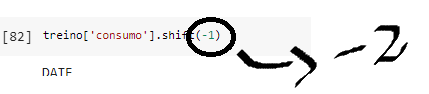



---

